# Mejores Modelos de NN con datos especies

## Parte Comun

In [1]:
#Grid de la segunda parte, en la que utilizamos ya la primera parte bien
#Esta va a ser la de las 44 variables con combined


#importamos paquetes
import sys
sys.path.append('Src/')
from data_modificado import * #hay funciones que estan cambiadas en este script para adaptralas a nuestro dataset
from train_2 import * #este hubo que modificar una linea tambien
from transfer_learning import * #hubo que modificart lo mismo que en train_2
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import itertools as it

#funciones
def read_df(
              metadata_names=['age','Temperature','Precipitation3Days'],
              random_state=42,
              otu_filename='../Datasets/otu_table_all_80.csv',
              metadata_filename='../Datasets/metadata_table_all_80.csv'):
    otu = pd.read_csv(otu_filename, index_col=0, header=None).T
    #print(otu.head())
    otu = otu.set_index('otuids')
    otu = otu.astype('int32')
    metadata = pd.read_csv(metadata_filename)
    #print(metadata.head())
    metadata = metadata.set_index('X.SampleID')
    metadata.head()
    domain = metadata[metadata_names]
    #if 'INBREDS' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['INBREDS'], prefix='INBREDS')], axis=1)
    #    domain = domain.drop(['INBREDS'], axis=1)
    #elif 'Maize_Line' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['Maize_Line'], prefix='Maize_Line')], axis=1)
    #    domain = domain.drop(['Maize_Line'], axis=1) 
    df = pd.concat([otu, domain], axis=1, sort=True, join='outer')
    #print(df.head())
    #data_microbioma = df[otu.columns].to_numpy(dtype=np.float32)
    #data_domain = df[domain.columns].to_numpy(dtype=np.float32)
    df_microbioma = df[otu.columns]
    df_domain = df[domain.columns]
    df_domain.head()
    df_microbioma_train, df_microbioma_no_train, df_domain_train, df_domain_no_train = \
        train_test_split(df_microbioma, df_domain, test_size=0.1, random_state=random_state)
    # Transfer learning subset
    df_microbioma_test, df_microbioma_transfer_learning, df_domain_test, df_domain_transfer_learning = \
        train_test_split(df_microbioma_no_train, df_domain_no_train, test_size=0.1, random_state=random_state)
    df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test = \
        train_test_split(df_microbioma_transfer_learning, df_domain_transfer_learning, test_size=0.3, random_state=random_state)
    
    return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns
    #return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns


def train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                batch_size, epochs, train_callbacks):
    all_models = model_fn()
    model, encoder_bioma, encoder_domain, decoder_bioma = all_models
    metrics_prefix = None
    if encoder_bioma is not None and encoder_domain is not None:
        x_train = (m_train, d_train)
        y_train = (m_train, m_train, z_train)
        x_test = (m_test, d_test)
        y_test = (m_test, m_test, z_test)
    elif encoder_bioma is not None:
        x_train = m_train
        y_train = m_train
        x_test = m_test
        y_test = m_test
        metrics_prefix = 'bioma'
    elif encoder_domain is not None:
        x_train = d_train
        y_train = m_train
        x_test = d_test
        y_test = m_test
        metrics_prefix = 'domain'

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
        batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    r = model.fit(train_dataset,
                  epochs=epochs,
                  validation_data=val_dataset,
                  callbacks=train_callbacks,
                  verbose=0)
    if metrics_prefix is not None:
        old_keys = r.history
        r.history = {}
        for k, v in old_keys.items():
            if k == 'loss' or k == 'val_loss':
                new_key = k
            elif k.startswith('val_'):
                new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
            else:
                new_key = '{}_{}'.format(metrics_prefix, k)
            r.history[new_key] = v
    del val_dataset
    del train_dataset
    del x_train
    del y_train
    del x_test
    del y_test
    return r, all_models

def train_2(model_fn,
          data_microbioma,
          data_domain,
          latent_space=10,
          folds=5,
          epochs=20,
          batch_size=128,
          learning_rate_scheduler=ExpDecayScheluder(),
          random_seed=347,
          verbose=0):
    data_zeros_latent = np.zeros((data_microbioma.shape[0], latent_space), dtype=data_microbioma.dtype)
    results = []
    models = []
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]
    if learning_rate_scheduler is not None:
        train_callbacks += [learning_rate_scheduler.make()]

    if folds <= 1:
        m_train, m_test = data_microbioma, data_microbioma
        d_train, d_test = data_domain, data_domain
        z_train, z_test = data_zeros_latent, data_zeros_latent
        tf.random.set_seed(random_seed)
        r, m = train_kfold(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                           batch_size, epochs, train_callbacks)
        results.append(r)
        models.append(m)

    else: #EL PROBLEMA ESTA AQUI, QUE HACE FALTA UN 
        kf = KFold(n_splits=folds, random_state=random_seed, shuffle=True)
        tf.random.set_seed(random_seed)

        for train_index, test_index in kf.split(data_microbioma):
            m_train, m_test = data_microbioma[train_index], data_microbioma[test_index]
            #print(m_train)
            #d_train, d_test = data_domain[train_index], data_domain[test_index]
            if data_domain is None:
                d_train, d_test = None, None
            else:
                d_train, d_test = data_domain[train_index], data_domain[test_index]
            #print(d_train)
            #Esto de hacer el if else ha funcionado, pero no se si hace lo que debe bien
            z_train, z_test = data_zeros_latent[train_index], data_zeros_latent[test_index]
            r, m = train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                               batch_size, epochs, train_callbacks)
            results.append(r)
            models.append(m)
    return results, models

def perform_experiment_2_mod(cv_folds, epochs, batch_size, learning_rate, optimizer,
                       learning_rate_scheduler, input_transform, output_transform,
                       reconstruction_loss, latent_space, layers,
                       activation, activation_latent,
                       data_microbioma_train, data_domain_train,
                       show_results=True, device='/CPU:0'): #Show results cambiado de False  aTrue
    if input_transform is not None:
        input_transform = input_transform()
    #----------    
    if output_transform is not None:
        output_transform = output_transform()
    #----------      
    if reconstruction_loss.__class__.__name__ == 'MakeLoss':
        reconstruction_loss = reconstruction_loss.make()
    else:
        reconstruction_loss = reconstruction_loss()
    domain_layers = [l // 16 for l in layers] ####que es esto???? Esto es para las capas del domain
    #print(domain_layers)
    bioma_autoencoder = " -> ".join(["b"] +
                                    [str(l) for l in layers] +
                                    [str(latent_space)] +
                                    [str(l) for l in reversed(layers)] +
                                    ["b"])
    #---------- 
    #esto solo se utiliza para el texto, es irrelevante para nuestro error
    if data_domain_train is not None:
        domain_autoencoder = " -> ".join(["d"] +
                                     [str(l) for l in domain_layers] +
                                     [str(latent_space)] +
                                     [str(l) for l in reversed(layers)] +
                                     ["b"])
        
    else: 
        domain_autoencoder = " "
    #---------- 
    #donde se usa domain autoencoder?
    in_transform_name = input_transform.__class__.__name__ if input_transform else "none"
    out_transform_name = output_transform.__class__.__name__ if output_transform else "none"
    lr_scheduler_text = learning_rate_scheduler[
        1] if learning_rate_scheduler is not None else "none"
    lr_text = learning_rate if learning_rate_scheduler is not None else "constant = {}".format(
        learning_rate)
    learning_rate_scheduler = learning_rate_scheduler[
        0] if learning_rate_scheduler is not None else None
    optimizer = optimizer(learning_rate=learning_rate)
    #---------- 
    experiment_parameters = [
        ("Input transform", in_transform_name),
        ("Output transform", out_transform_name),
        ("Reconstruction Loss", reconstruction_loss.__class__.__name__),
        ("Latent Space", latent_space),
        ("Bioma Autoencoder", bioma_autoencoder),
        ("Domain Autoencoder", domain_autoencoder),
        ("Activation Encoder", activation),
        ("Activation Decoder", activation),
        ("Activation Latent", activation_latent),
        ("CV folds", cv_folds),
        ("Epochs", epochs),
        ("Batch Size", batch_size),
        ("Learning Rate Scheduler", lr_scheduler_text),
        ("Learning Rate", lr_text),
        ("Optimizer", optimizer.__class__.__name__),
    ]
    #----------  
    if show_results:
        md_text = ""
        md_text += "| Parameter             | Value         |\n"
        md_text += "|:----------------------|:--------------|\n"
        for n, v in experiment_parameters:
            md_text += "| {} | {} |\n".format(n, v)

        display(Markdown(md_text))
    #------------
    def create_model(print_data=False):
        bioma_shape=data_microbioma_train.shape[1]
        
        if data_domain_train is not None:
            domain_shape=data_domain_train.shape[1]
            #print("data_domain_train!=None")
        else:
            domain_shape=None
            #print("data_domain_train==None")
        models = autoencoder(bioma_shape=bioma_shape,
                             #bioma_shape=717,
                             domain_shape=domain_shape,
                             output_shape=bioma_shape,
                             #output_shape=717,
                             latent_space=latent_space,
                             bioma_layers=layers, #Esto es lo de [512,316]
                             domain_layers=domain_layers, #Esto son cada una de las layers divididas por 16
                             input_transform=input_transform,
                             output_transform=output_transform,
                             activation_function_encoder=activation,
                             activation_function_decoder=activation,
                             activation_function_latent=activation_latent)
        #Entiendo analizando lo demas que aqui NO esta el error
        #la funcion autoencoder esta en model.py (es la unica funcion en ese script)
        
        model, encoder_bioma, encoder_domain, decoder_bioma = models

        if print_data:
            plot_models(model, encoder_bioma, encoder_domain, decoder_bioma)
        compile_train(model,
                      encoder_bioma=encoder_bioma,
                      encoder_domain=encoder_domain,
                      reconstruction_error=reconstruction_loss,
                      encoded_comparison_error=losses.MeanAbsoluteError(),
                      metrics=get_experiment_metrics(input_transform, output_transform),
                      optimizer=optimizer)
        
        #print("He acabado create_model :)")
        return model, encoder_bioma, encoder_domain, decoder_bioma
    #-----------
    create_model(print_data=False)
    #-----------
    #Esta en esta seccion el problema, en train_2
    #print(data_domain_train)
    #print(latent_space)
    with tf.device(device):
        results, models = train_2(create_model,
                                data_microbioma_train,
                                data_domain_train,
                                latent_space=latent_space,
                                folds=cv_folds,
                                epochs=epochs,
                                batch_size=batch_size,
                                learning_rate_scheduler=learning_rate_scheduler,
                                verbose=-1)
    #----------
    validation_results = print_results(results, show_results=show_results)
    if show_results:
        display(Markdown("*************"))

    return experiment_parameters + validation_results, models, results

-----------------------
## 44 Latent Space Combined

In [3]:
#Cargamos los datos
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_especies/otu_table_especies_80.csv',metadata_filename='resultados_ana/datos_otus_metadatos_especies/metadatos_nutrientes.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | softmax |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.01 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.6998 (min: 0.6998, max: 0.6998)

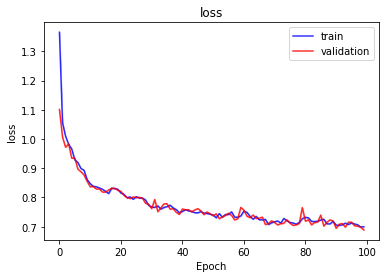

<b>bioma_loss</b>: 0.2087 (min: 0.2087, max: 0.2087)

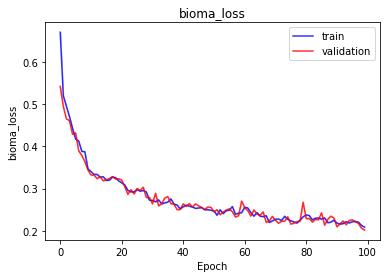

<b>domain_loss</b>: 0.4684 (min: 0.4684, max: 0.4684)

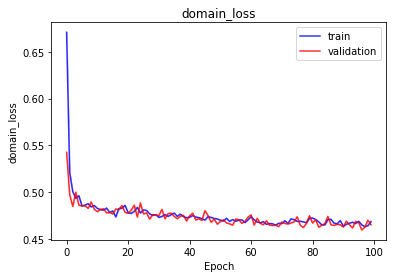

<b>latent_loss</b>: 0.0227 (min: 0.0227, max: 0.0227)

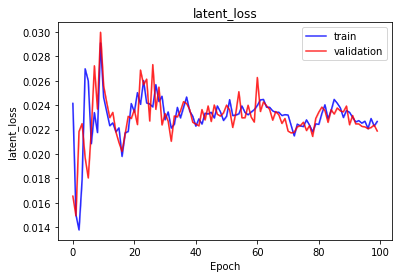

<b>bioma_mse</b>: 5217016.0000 (min: 5217016.0000, max: 5217016.0000)

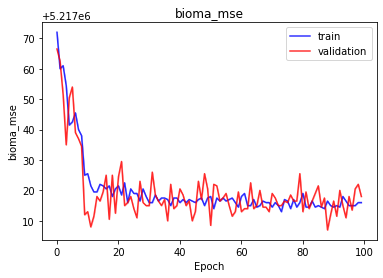

<b>bioma_mae</b>: 219.5105 (min: 219.5105, max: 219.5105)

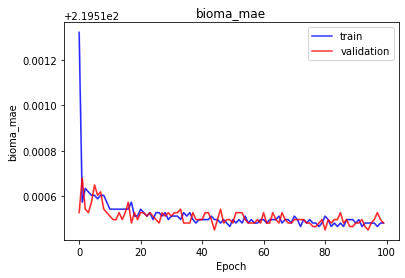

<b>bioma_mape</b>: 37982.8086 (min: 37982.8086, max: 37982.8086)

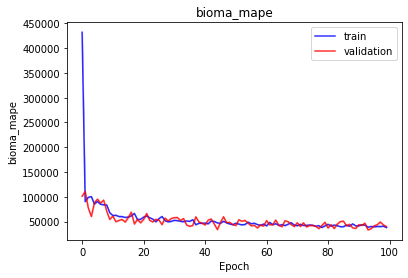

<b>bioma_BrayCurtis</b>: 0.2087 (min: 0.2087, max: 0.2087)

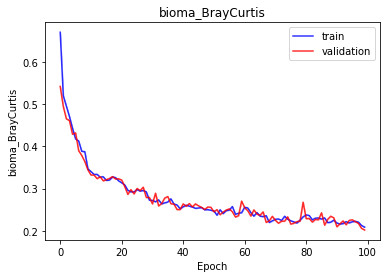

<b>bioma_pearson_corr</b>: 0.9381 (min: 0.9381, max: 0.9381)

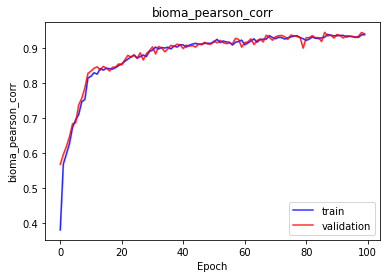

<b>bioma_jensen_shannon_divergence</b>: 0.3622 (min: 0.3622, max: 0.3622)

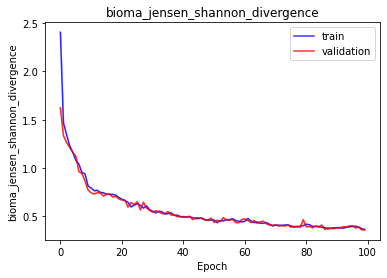

<b>domain_mse</b>: 5217056.5000 (min: 5217056.5000, max: 5217056.5000)

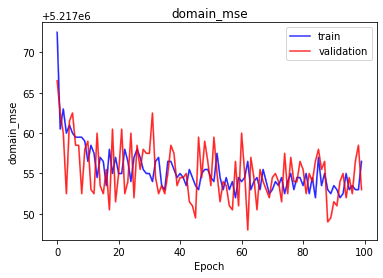

<b>domain_mae</b>: 219.5106 (min: 219.5106, max: 219.5106)

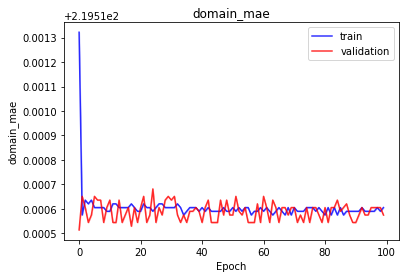

<b>domain_mape</b>: 84087.2109 (min: 84087.2109, max: 84087.2109)

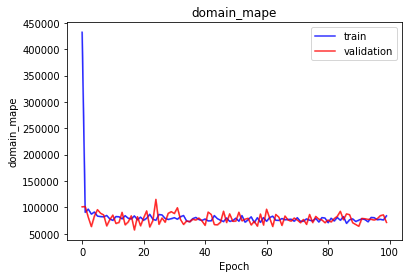

<b>domain_BrayCurtis</b>: 0.4684 (min: 0.4684, max: 0.4684)

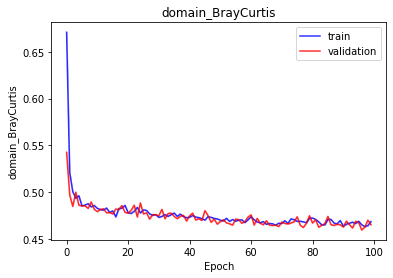

<b>domain_pearson_corr</b>: 0.6262 (min: 0.6262, max: 0.6262)

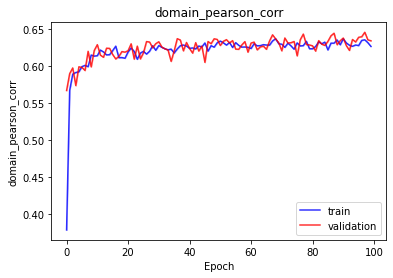

<b>domain_jensen_shannon_divergence</b>: 1.2202 (min: 1.2202, max: 1.2202)

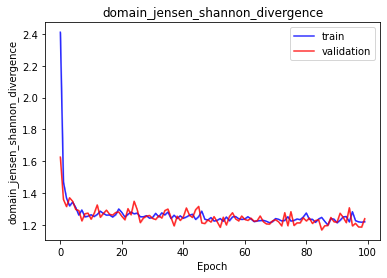

<b>latent_mae</b>: 0.0227 (min: 0.0227, max: 0.0227)

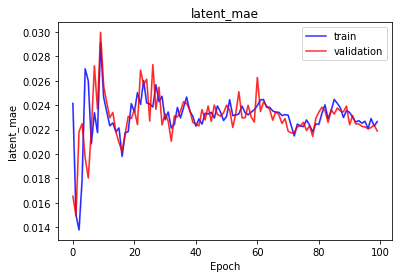

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.699763834476471 | 0.699763834476471 | 0.699763834476471 |
| bioma_loss | 0.20867019891738892 | 0.20867019891738892 | 0.20867019891738892 |
| domain_loss | 0.4684336483478546 | 0.4684336483478546 | 0.4684336483478546 |
| latent_loss | 0.022659987211227417 | 0.022659987211227417 | 0.022659987211227417 |
| bioma_mse | 5217016.0 | 5217016.0 | 5217016.0 |
| bioma_mae | 219.51048278808594 | 219.51048278808594 | 219.51048278808594 |
| bioma_mape | 37982.80859375 | 37982.80859375 | 37982.80859375 |
| bioma_BrayCurtis | 0.20867019891738892 | 0.20867019891738892 | 0.20867019891738892 |
| bioma_pearson_corr | 0.9381106495857239 | 0.9381106495857239 | 0.9381106495857239 |
| bioma_jensen_shannon_divergence | 0.3621833324432373 | 0.3621833324432373 | 0.3621833324432373 |
| domain_mse | 5217056.5 | 5217056.5 | 5217056.5 |
| domain_mae | 219.51060485839844 | 219.51060485839844 | 219.51060485839844 |
| domain_mape | 84087.2109375 | 84087.2109375 | 84087.2109375 |
| domain_BrayCurtis | 0.4684336483478546 | 0.4684336483478546 | 0.4684336483478546 |
| domain_pearson_corr | 0.6261709928512573 | 0.6261709928512573 | 0.6261709928512573 |
| domain_jensen_shannon_divergence | 1.2202287912368774 | 1.2202287912368774 | 1.2202287912368774 |
| latent_mae | 0.022659987211227417 | 0.022659987211227417 | 0.022659987211227417 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4534071385860443 | 0.4534071385860443 | 0.4534071385860443 |
| pearson_corr | 0.6666126251220703 | 0.6666126251220703 | 0.6666126251220703 |
| jensen_shannon_divergence | 1.1859110593795776 | 1.1859110593795776 | 1.1859110593795776 |


In [4]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.01,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='softmax',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='softmax')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

-----------------------
## 44 Latent Space OTU

In [5]:
#Cargamos los datos
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_especies/otu_table_especies_80.csv',metadata_filename='resultados_ana/datos_otus_metadatos_especies/metadatos_nutrientes.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>95</b></p>

<b>loss</b>: 0.1720 (min: 0.1720, max: 0.1720)

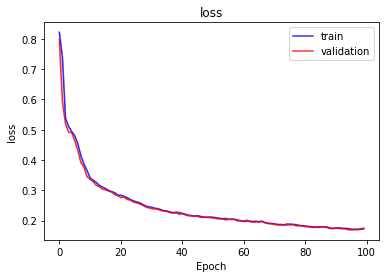

<b>bioma_mse</b>: 5217014.5000 (min: 5217014.5000, max: 5217014.5000)

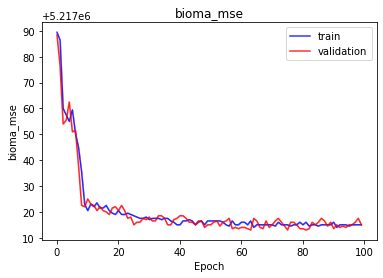

<b>bioma_mae</b>: 219.5105 (min: 219.5105, max: 219.5105)

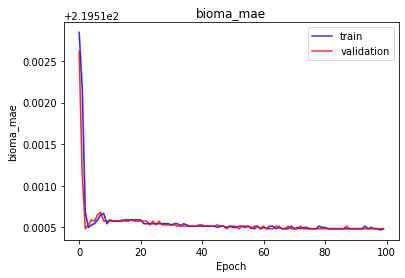

<b>bioma_mape</b>: 39895.5625 (min: 39895.5625, max: 39895.5625)

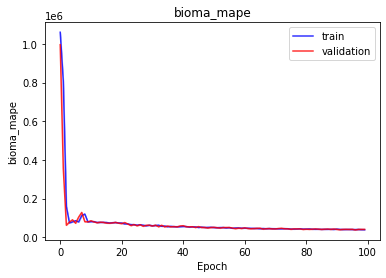

<b>bioma_BrayCurtis</b>: 0.1720 (min: 0.1720, max: 0.1720)

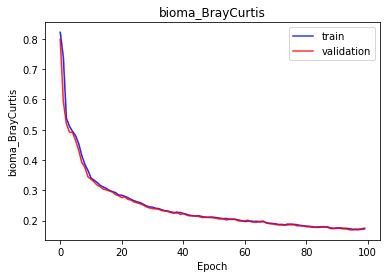

<b>bioma_pearson_corr</b>: 0.9550 (min: 0.9550, max: 0.9550)

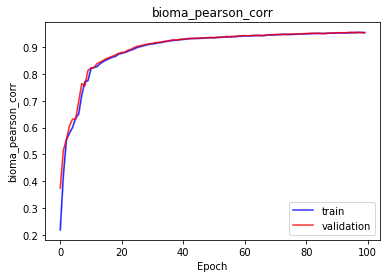

<b>bioma_jensen_shannon_divergence</b>: 0.3410 (min: 0.3410, max: 0.3410)

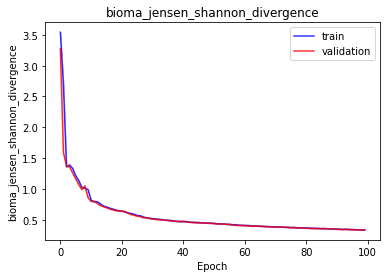

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.1720302402973175 | 0.1720302402973175 | 0.1720302402973175 |
| bioma_mse | 5217014.5 | 5217014.5 | 5217014.5 |
| bioma_mae | 219.510498046875 | 219.510498046875 | 219.510498046875 |
| bioma_mape | 39895.5625 | 39895.5625 | 39895.5625 |
| bioma_BrayCurtis | 0.1720302402973175 | 0.1720302402973175 | 0.1720302402973175 |
| bioma_pearson_corr | 0.9550129771232605 | 0.9550129771232605 | 0.9550129771232605 |
| bioma_jensen_shannon_divergence | 0.34102556109428406 | 0.34102556109428406 | 0.34102556109428406 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4550451338291168 | 0.4550451338291168 | 0.4550451338291168 |
| pearson_corr | 0.6619402170181274 | 0.6619402170181274 | 0.6619402170181274 |
| jensen_shannon_divergence | 1.1394068002700806 | 1.1394068002700806 | 1.1394068002700806 |


In [6]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='softmax')(in_layer)
    net = layers.Dense(64, activation='softmax')(net)
    net = layers.Dense(32, activation='softmax')(net)
    net = layers.Dense(16, activation='softmax')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

-----------------------
## 22 Latent Space Combined

In [7]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_especies/otu_table_especies_80.csv',metadata_filename='resultados_ana/datos_otus_metadatos_especies/metadatos_nutrientes.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.7228 (min: 0.7228, max: 0.7228)

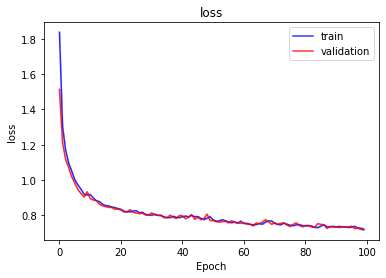

<b>bioma_loss</b>: 0.2375 (min: 0.2375, max: 0.2375)

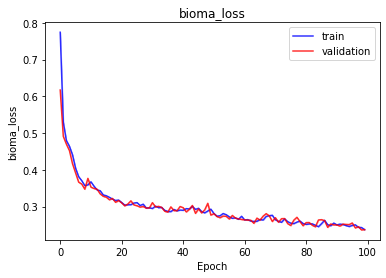

<b>domain_loss</b>: 0.4513 (min: 0.4513, max: 0.4513)

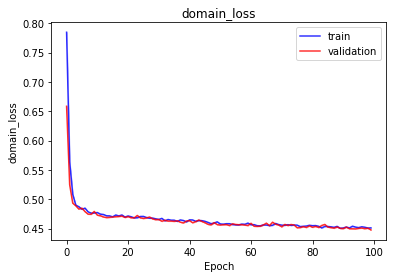

<b>latent_loss</b>: 0.0340 (min: 0.0340, max: 0.0340)

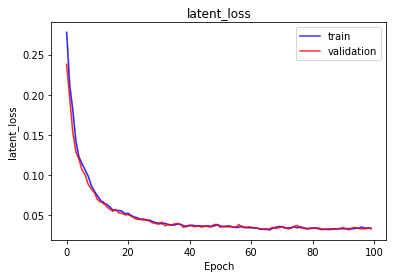

<b>bioma_mse</b>: 5217016.0000 (min: 5217016.0000, max: 5217016.0000)

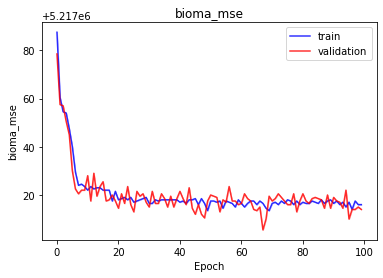

<b>bioma_mae</b>: 219.5105 (min: 219.5105, max: 219.5105)

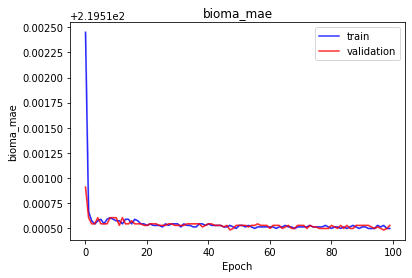

<b>bioma_mape</b>: 49151.1016 (min: 49151.1016, max: 49151.1016)

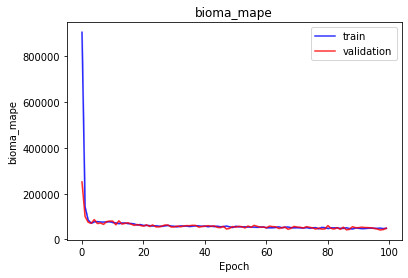

<b>bioma_BrayCurtis</b>: 0.2375 (min: 0.2375, max: 0.2375)

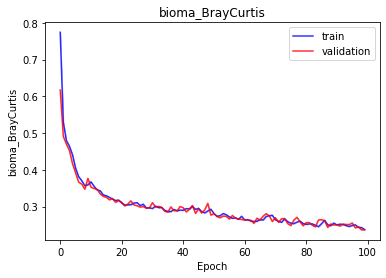

<b>bioma_pearson_corr</b>: 0.9199 (min: 0.9199, max: 0.9199)

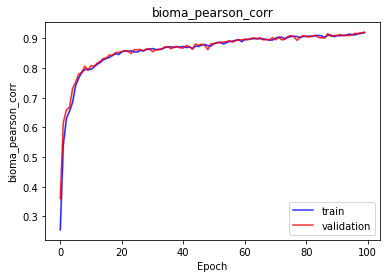

<b>bioma_jensen_shannon_divergence</b>: 0.4894 (min: 0.4894, max: 0.4894)

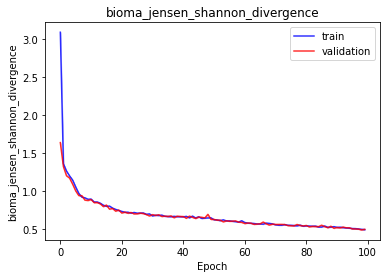

<b>domain_mse</b>: 5217051.5000 (min: 5217051.5000, max: 5217051.5000)

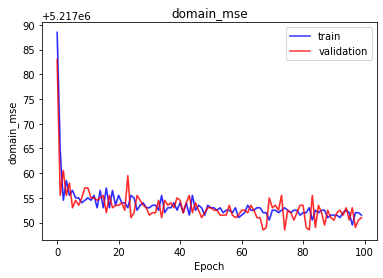

<b>domain_mae</b>: 219.5106 (min: 219.5106, max: 219.5106)

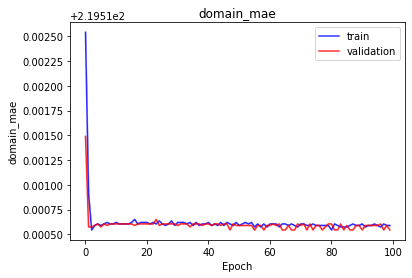

<b>domain_mape</b>: 75925.8750 (min: 75925.8750, max: 75925.8750)

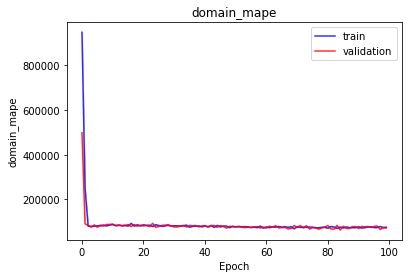

<b>domain_BrayCurtis</b>: 0.4513 (min: 0.4513, max: 0.4513)

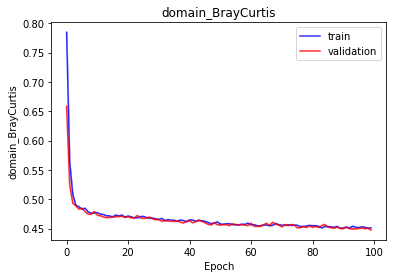

<b>domain_pearson_corr</b>: 0.6579 (min: 0.6579, max: 0.6579)

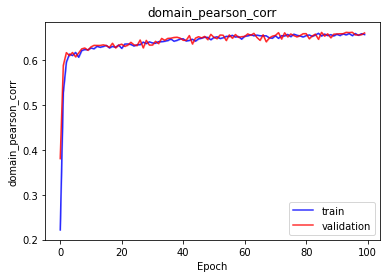

<b>domain_jensen_shannon_divergence</b>: 1.1622 (min: 1.1622, max: 1.1622)

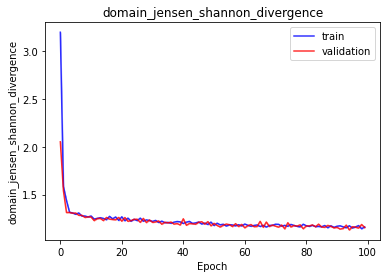

<b>latent_mae</b>: 0.0340 (min: 0.0340, max: 0.0340)

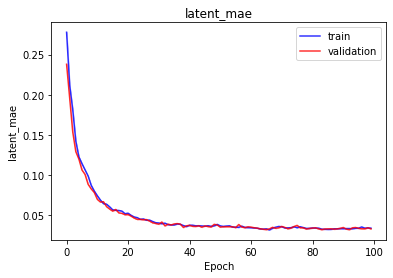

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.722777783870697 | 0.722777783870697 | 0.722777783870697 |
| bioma_loss | 0.237540140748024 | 0.237540140748024 | 0.237540140748024 |
| domain_loss | 0.4512777030467987 | 0.4512777030467987 | 0.4512777030467987 |
| latent_loss | 0.033959921449422836 | 0.033959921449422836 | 0.033959921449422836 |
| bioma_mse | 5217016.0 | 5217016.0 | 5217016.0 |
| bioma_mae | 219.510498046875 | 219.510498046875 | 219.510498046875 |
| bioma_mape | 49151.1015625 | 49151.1015625 | 49151.1015625 |
| bioma_BrayCurtis | 0.237540140748024 | 0.237540140748024 | 0.237540140748024 |
| bioma_pearson_corr | 0.9199326634407043 | 0.9199326634407043 | 0.9199326634407043 |
| bioma_jensen_shannon_divergence | 0.4893779456615448 | 0.4893779456615448 | 0.4893779456615448 |
| domain_mse | 5217051.5 | 5217051.5 | 5217051.5 |
| domain_mae | 219.51058959960938 | 219.51058959960938 | 219.51058959960938 |
| domain_mape | 75925.875 | 75925.875 | 75925.875 |
| domain_BrayCurtis | 0.4512777030467987 | 0.4512777030467987 | 0.4512777030467987 |
| domain_pearson_corr | 0.6579332947731018 | 0.6579332947731018 | 0.6579332947731018 |
| domain_jensen_shannon_divergence | 1.162182331085205 | 1.162182331085205 | 1.162182331085205 |
| latent_mae | 0.033959921449422836 | 0.033959921449422836 | 0.033959921449422836 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.45467084646224976 | 0.45467084646224976 | 0.45467084646224976 |
| pearson_corr | 0.6679733991622925 | 0.6679733991622925 | 0.6679733991622925 |
| jensen_shannon_divergence | 1.1702316999435425 | 1.1702316999435425 | 1.1702316999435425 |


In [8]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

-----------------------
## 22 Latent Space OTU

In [9]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_especies/otu_table_especies_80.csv',metadata_filename='resultados_ana/datos_otus_metadatos_especies/metadatos_nutrientes.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>98</b></p>

<b>loss</b>: 0.7466 (min: 0.7466, max: 0.7466)

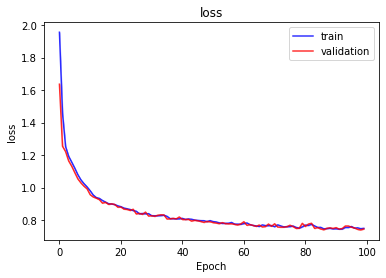

<b>bioma_loss</b>: 0.2447 (min: 0.2447, max: 0.2447)

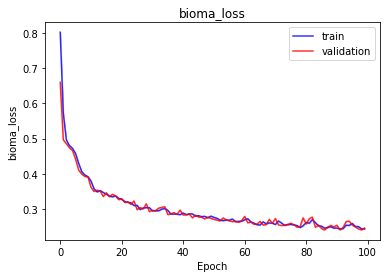

<b>domain_loss</b>: 0.4647 (min: 0.4647, max: 0.4647)

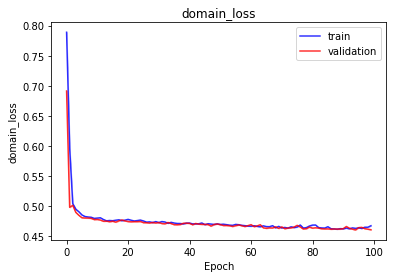

<b>latent_loss</b>: 0.0372 (min: 0.0372, max: 0.0372)

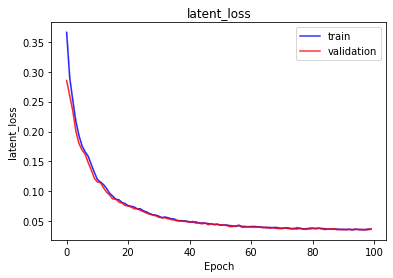

<b>bioma_mse</b>: 5217017.5000 (min: 5217017.5000, max: 5217017.5000)

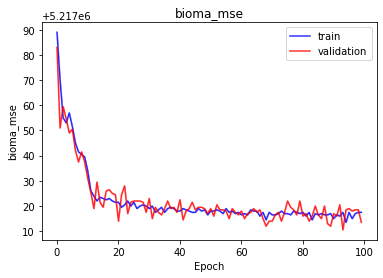

<b>bioma_mae</b>: 219.5105 (min: 219.5105, max: 219.5105)

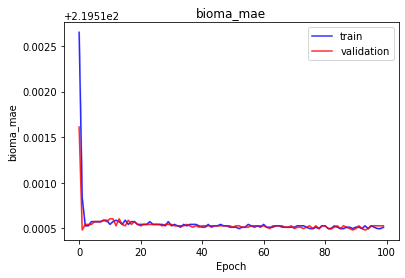

<b>bioma_mape</b>: 52083.3477 (min: 52083.3477, max: 52083.3477)

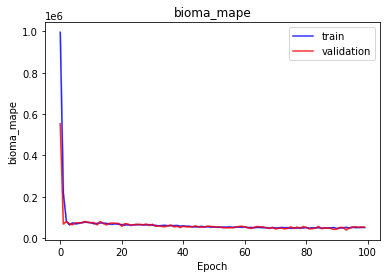

<b>bioma_BrayCurtis</b>: 0.2447 (min: 0.2447, max: 0.2447)

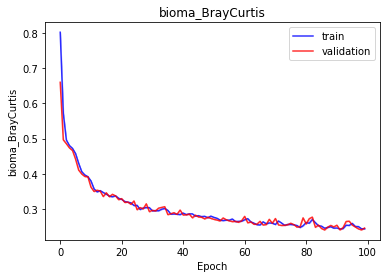

<b>bioma_pearson_corr</b>: 0.9158 (min: 0.9158, max: 0.9158)

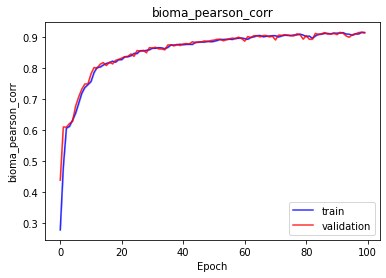

<b>bioma_jensen_shannon_divergence</b>: 0.5134 (min: 0.5134, max: 0.5134)

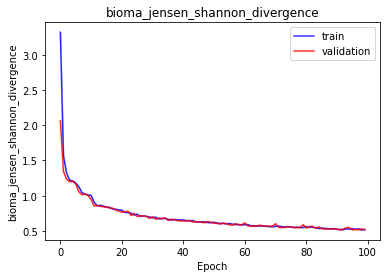

<b>domain_mse</b>: 5217051.0000 (min: 5217051.0000, max: 5217051.0000)

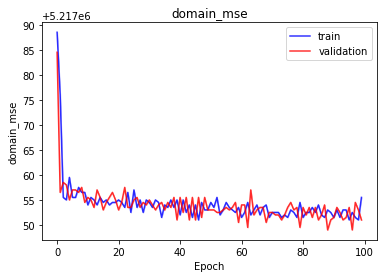

<b>domain_mae</b>: 219.5106 (min: 219.5106, max: 219.5106)

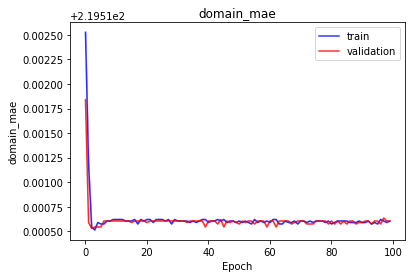

<b>domain_mape</b>: 79762.9688 (min: 79762.9688, max: 79762.9688)

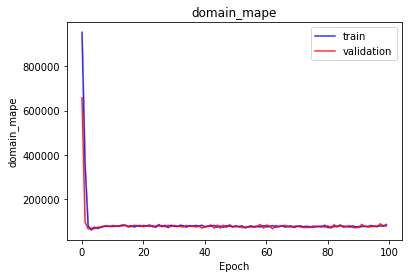

<b>domain_BrayCurtis</b>: 0.4647 (min: 0.4647, max: 0.4647)

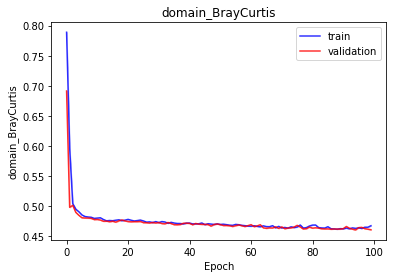

<b>domain_pearson_corr</b>: 0.6365 (min: 0.6365, max: 0.6365)

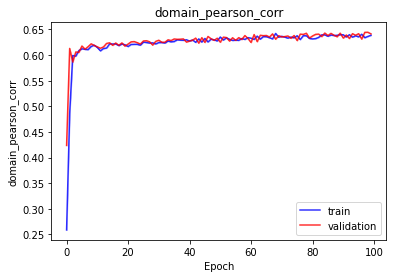

<b>domain_jensen_shannon_divergence</b>: 1.2085 (min: 1.2085, max: 1.2085)

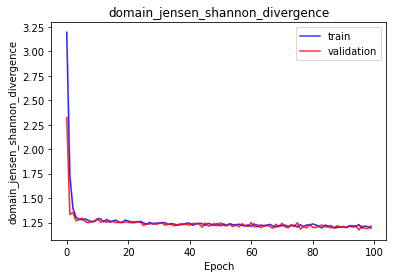

<b>latent_mae</b>: 0.0372 (min: 0.0372, max: 0.0372)

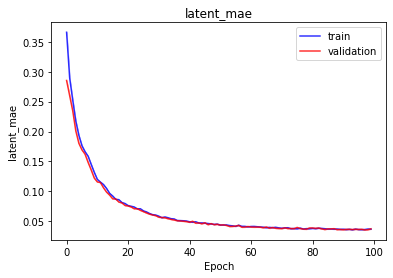

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.7465824484825134 | 0.7465824484825134 | 0.7465824484825134 |
| bioma_loss | 0.24467040598392487 | 0.24467040598392487 | 0.24467040598392487 |
| domain_loss | 0.4647022783756256 | 0.4647022783756256 | 0.4647022783756256 |
| latent_loss | 0.03720973804593086 | 0.03720973804593086 | 0.03720973804593086 |
| bioma_mse | 5217017.5 | 5217017.5 | 5217017.5 |
| bioma_mae | 219.510498046875 | 219.510498046875 | 219.510498046875 |
| bioma_mape | 52083.34765625 | 52083.34765625 | 52083.34765625 |
| bioma_BrayCurtis | 0.24467040598392487 | 0.24467040598392487 | 0.24467040598392487 |
| bioma_pearson_corr | 0.9158458113670349 | 0.9158458113670349 | 0.9158458113670349 |
| bioma_jensen_shannon_divergence | 0.5134410262107849 | 0.5134410262107849 | 0.5134410262107849 |
| domain_mse | 5217051.0 | 5217051.0 | 5217051.0 |
| domain_mae | 219.51058959960938 | 219.51058959960938 | 219.51058959960938 |
| domain_mape | 79762.96875 | 79762.96875 | 79762.96875 |
| domain_BrayCurtis | 0.4647022783756256 | 0.4647022783756256 | 0.4647022783756256 |
| domain_pearson_corr | 0.6364917755126953 | 0.6364917755126953 | 0.6364917755126953 |
| domain_jensen_shannon_divergence | 1.2084789276123047 | 1.2084789276123047 | 1.2084789276123047 |
| latent_mae | 0.03720973804593086 | 0.03720973804593086 | 0.03720973804593086 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4764680564403534 | 0.4764680564403534 | 0.4764680564403534 |
| pearson_corr | 0.649135947227478 | 0.649135947227478 | 0.649135947227478 |
| jensen_shannon_divergence | 1.2082154750823975 | 1.2082154750823975 | 1.2082154750823975 |


In [10]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)